# Analyze Health Data

-----

## Backlog

- Add CI and code coverage to my git repos
- Build model of caloric steps equivalent to convert rides into steps
- Calories
- Add vertical lines to mark surgery & novo start dates
- Bar charts with steps/workouts side by side

- Aggregate stairmaster, eliptical, rower, etc...
- Ideally create single merged data table of daily fitness stats
- Workout data
- Mindfulness minutes
- VO2max
- Integrate w/strava
- Need strava data to get calories from cycling workouts I think.

## Dependencies and Libraries

In [1]:
from datetime import date, datetime, timedelta as td
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
import seaborn as sns
%matplotlib inline

## Data Extraction

In [2]:
%run -i 'apple-health-data-parser' 'data/export.xml'

Reading data from data/export.xml . . . done


apple-health-data-parser.py:136: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  self.nodes = self.root.getchildren()


Unexpected node of type ExportDate.

Tags:
ActivitySummary: 711
ExportDate: 1
Me: 1
Record: 1527977
Workout: 282

Fields:
HKCharacteristicTypeIdentifierBiologicalSex: 1
HKCharacteristicTypeIdentifierBloodType: 1
HKCharacteristicTypeIdentifierDateOfBirth: 1
HKCharacteristicTypeIdentifierFitzpatrickSkinType: 1
activeEnergyBurned: 711
activeEnergyBurnedGoal: 711
activeEnergyBurnedUnit: 711
appleExerciseTime: 711
appleExerciseTimeGoal: 711
appleStandHours: 711
appleStandHoursGoal: 711
creationDate: 1528259
dateComponents: 711
device: 1505217
duration: 282
durationUnit: 282
endDate: 1528259
sourceName: 1528259
sourceVersion: 1521972
startDate: 1528259
totalDistance: 282
totalDistanceUnit: 282
totalEnergyBurned: 282
totalEnergyBurnedUnit: 282
type: 1527977
unit: 1516192
value: 1527724
workoutActivityType: 282

Record types:
ActiveEnergyBurned: 677150
AppleExerciseTime: 31229
AppleStandHour: 11529
AppleStandTime: 7100
AudioExposureEvent: 2
BasalEnergyBurned: 240630
BodyMass: 391
DietaryCalciu

------

## Steps

In [208]:
steps = pd.read_csv("data/StepCount.csv")
# steps.tail()

# parse out date and time elements as EST time
steps['startDate'] = pd.to_datetime(steps['startDate'], utc=True).dt.tz_convert('EST')
steps['endDate'] = pd.to_datetime(steps['endDate'], utc=True).dt.tz_convert('EST')
steps['date'] = steps['startDate'].dt.strftime('%Y-%m-%d')
steps['doy'] = steps['startDate'].dt.dayofyear

#drop irrelevant columns
steps = steps.drop(['device', 'creationDate', 'type', 'unit', 'sourceVersion'], axis=1)

#sort
steps = steps.sort_values(['startDate'])

# print(steps.head())
# print(steps.tail(10))
# print(steps.shape)

### Import and Merge Fitbit data

In [209]:
# Read fitbit csv
fb = pd.read_csv('data/fitbit_master.csv')

# parse out date and time elements as EST time
fb['Date'] = pd.to_datetime(fb['Date'])#.dt.tz_convert('EST')
fb['date'] = fb['Date'].dt.strftime('%Y-%m-%d')
fb['sourceName'] = 'FitBit'
fb2=fb[['sourceName','date', 'Steps']]

# print(fb2.tail())

# Aggregate apple watch data by date
steps_by_dateX = steps.groupby(['sourceName','date'])['value'].sum().reset_index(name='Steps')

#merge with fitbit data
steps_by_dateX = pd.concat([fb2, steps_by_dateX], ignore_index=True)

print(steps_by_dateX.tail())

              sourceName        date  Steps
2172  Greg’s Apple Watch  2020-05-18  16676
2173  Greg’s Apple Watch  2020-05-19  13815
2174  Greg’s Apple Watch  2020-05-20  11920
2175  Greg’s Apple Watch  2020-05-21  19572
2176  Greg’s Apple Watch  2020-05-22  22348


### Clean Daily Steps Data

In [210]:
#sort and drop lowest
steps_by_dateX = steps_by_dateX.sort_values(['date', 'Steps'])
steps_by_dateX = steps_by_dateX.drop_duplicates('date', keep='last').reset_index(drop=True)

steps_by_date = steps_by_dateX.drop('sourceName', axis=1)
# print(steps_by_date.head())
print(steps_by_date.tail())

            date  Steps
1294  2020-05-18  16676
1295  2020-05-19  13815
1296  2020-05-20  11920
1297  2020-05-21  19572
1298  2020-05-22  23021


### Histogram of Steps

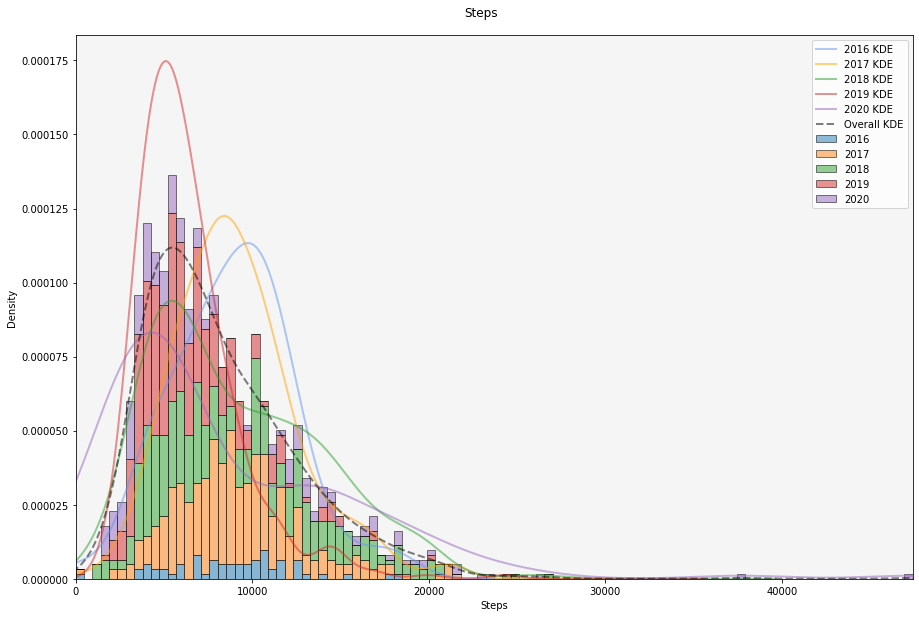

In [211]:
df = steps_by_date.copy()
df['date'] = pd.to_datetime(df['date'])

#Specify distribution parameters
bn = 100

#plot histogram of steps
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.suptitle('Steps', fontsize=12, y=.92)
n, bins, patches = plt.hist([df[df.date.dt.year==2016].Steps,df[df.date.dt.year==2017].Steps,df[df.date.dt.year==2018].Steps,df[df.date.dt.year==2019].Steps, df[df.date.dt.year==2020].Steps], bn, density=True, alpha =0.5, histtype='barstacked', label=['2016', '2017', '2018', '2019', '2020'], edgecolor='black')

df[df.date.dt.year==2016].Steps.plot.kde(c='cornflowerblue', alpha = 0.5, linewidth=2, label = '2016 KDE')
df[df.date.dt.year==2017].Steps.plot.kde(c= 'orange', alpha = 0.5, linewidth=2, label = '2017 KDE')
df[df.date.dt.year==2018].Steps.plot.kde(c='tab:green', alpha = 0.5, linewidth=2, label = '2018 KDE')
df[df.date.dt.year==2019].Steps.plot.kde(c='tab:red', alpha = 0.5, linewidth=2, label = '2019 KDE')
df[df.date.dt.year==2020].Steps.plot.kde(c='tab:purple', alpha = 0.5, linewidth=2, label = '2020 KDE')
df.Steps.plot.kde(c='k', alpha = 0.5, linewidth=2, linestyle='dashed', label = 'Overall KDE')

plt.xlim((0,df.Steps.max()))
plt.xlabel('Steps')
plt.legend(loc=1)
plt.show()

Text(0.5, 0, 'Year')

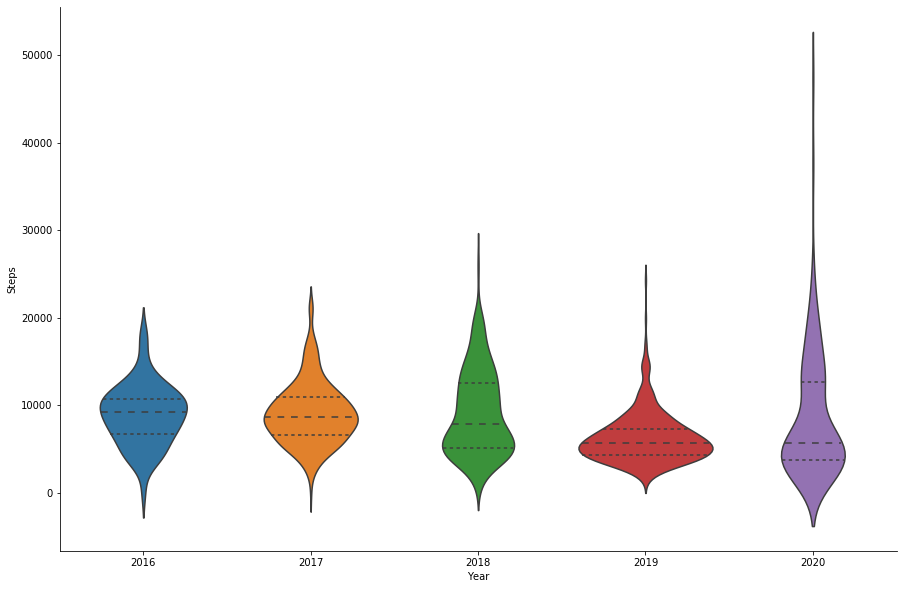

In [212]:
df = steps_by_date.copy()
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

plt.figure(figsize=(15,10))
sns.violinplot(x='year', y='Steps', data=df, inner="quart")
sns.despine(left=False)
plt.xlabel('Year')

### Rolling average

In [213]:
steps_by_date2=steps_by_date.copy()

steps_by_date2['date'] = pd.to_datetime(steps_by_date2['date'])
steps_by_date2['days_elapsed'] = (steps_by_date2['date']-steps_by_date2['date'].min()).dt.days +1
steps_by_date2['steps_expected'] = steps_by_date2['days_elapsed']*10000
steps_by_date2['steps_total'] = steps_by_date2['Steps'].cumsum()
steps_by_date2['steps_deficit'] = steps_by_date2['steps_expected'] - steps_by_date2['steps_total']

steps_by_date2=steps_by_date2.set_index('date')

# print(steps_by_date2.head())
print(steps_by_date2.tail())

            Steps  days_elapsed  steps_expected  steps_total  steps_deficit
date                                                                       
2020-05-18  16676          1295        12950000     10648712        2301288
2020-05-19  13815          1296        12960000     10662527        2297473
2020-05-20  11920          1297        12970000     10674447        2295553
2020-05-21  19572          1298        12980000     10694019        2285981
2020-05-22  23021          1299        12990000     10717040        2272960


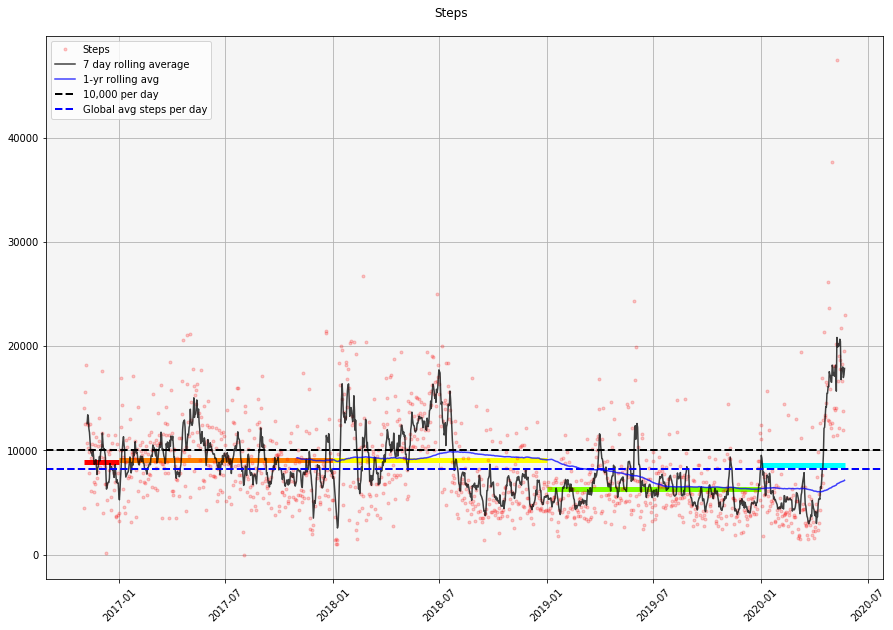

In [214]:
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.suptitle('Steps', fontsize=12, y=.92)
plt.grid(True)
plt.plot(steps_by_date2['Steps'], 'r.', alpha=0.2,label='Steps')
plt.plot(steps_by_date2.Steps.rolling(window=7, center=False).mean(), c='k',label='7 day rolling average', alpha=0.75)
plt.plot(steps_by_date2.Steps.rolling(window=365, center=False).mean(), c='blue', label='1-yr rolling avg', alpha =0.75)

ax.axhline(10000, linewidth=2, color='k', linestyle='dashed',label="10,000 per day")
ax.axhline(steps_by_date2.Steps.mean(), linewidth=2, color='blue', linestyle='dashed',label="Global avg steps per day")

plt.hlines(steps_by_date2.resample('Y').mean().iloc[0,0],steps_by_date2.index.min(), steps_by_date2.resample('Y').mean().index[0], colors=(1,0,0,1), linewidths=(5,))
plt.hlines(steps_by_date2.resample('Y').mean().iloc[1,0],steps_by_date2.resample('Y').mean().index[0], steps_by_date2.resample('Y').mean().index[1], colors=(1,0.5,0,1), linewidths=(5,))
plt.hlines(steps_by_date2.resample('Y').mean().iloc[2,0],steps_by_date2.resample('Y').mean().index[1], steps_by_date2.resample('Y').mean().index[2], colors=(1,1,0,1), linewidths=(5,))
plt.hlines(steps_by_date2.resample('Y').mean().iloc[3,0],steps_by_date2.resample('Y').mean().index[2], steps_by_date2.resample('Y').mean().index[3], colors=(0.5,1,0,1), linewidths=(5,))
plt.hlines(steps_by_date2.resample('Y').mean().iloc[4,0],steps_by_date2.resample('Y').mean().index[3], steps_by_date2.index.max(), colors=(0,1,1,1), linewidths=(5,))

plt.legend(loc=2)
plt.xticks(rotation=45)

plt.show()

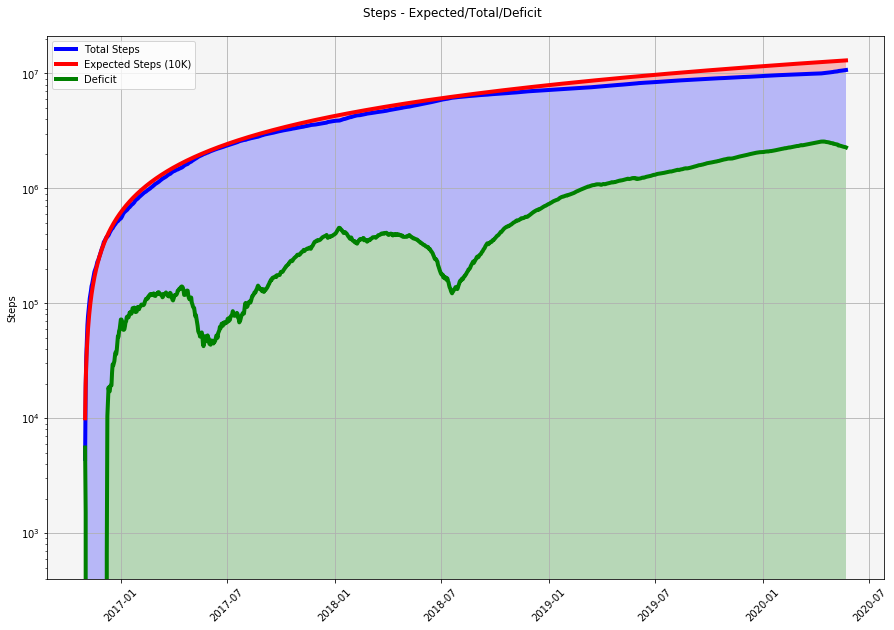

My current deficit is 2,272,960 steps
Steps                 7622
days_elapsed          1260
steps_expected    12600000
steps_total       10040755
steps_deficit      2559245
Name: 2020-04-13 00:00:00, dtype: int64


In [219]:
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.suptitle('Steps - Expected/Total/Deficit', fontsize=12, y=.92)
plt.grid(True)
plt.plot(steps_by_date2['steps_total'], alpha=1,label='Total Steps', linewidth=4, c='blue')
plt.plot(steps_by_date2['steps_expected'], alpha=1,label='Expected Steps (10K)', linewidth=4, c='r')
plt.plot(steps_by_date2['steps_deficit'], alpha=1,label='Deficit', linewidth=4, c='green')
ax.fill_between(steps_by_date2.index,steps_by_date2['steps_total'], steps_by_date2['steps_deficit'], facecolor='blue', alpha=0.25)
ax.fill_between(steps_by_date2.index,steps_by_date2['steps_expected'], steps_by_date2['steps_total'], facecolor='r', alpha=0.25)
ax.fill_between(steps_by_date2.index, steps_by_date2['steps_deficit'], facecolor='green', alpha=0.25)

plt.yscale('log')
plt.ylabel("Steps")
plt.legend(loc=2)
plt.xticks(rotation=45)

plt.show()

print('My current deficit is {:,} steps'.format(steps_by_date2.steps_deficit[-1]))
print(steps_by_date2.iloc[steps_by_date2.steps_deficit.argmax()])

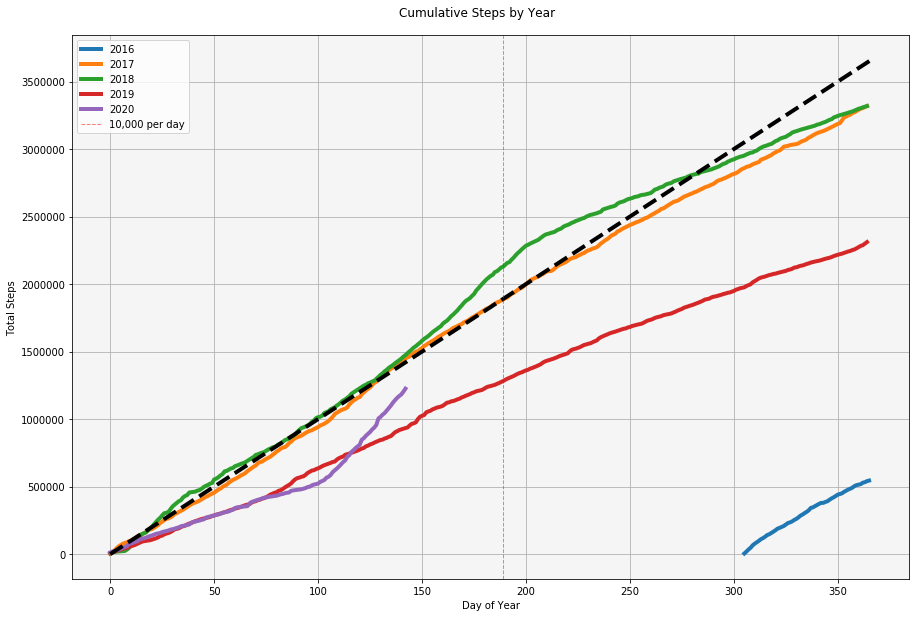

In [220]:
df = steps_by_date.copy()
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['doy'] = df['date'].dt.dayofyear

steps_by_year = pd.pivot_table(df, index='doy', columns='year', values='Steps', aggfunc='sum').reset_index().rename_axis(None, axis=1)

plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.suptitle('Cumulative Steps by Year', fontsize=12, y=.92)
plt.grid(True)
plt.plot(steps_by_year[2016].cumsum(), label='2016', linewidth=4)
plt.plot(steps_by_year[2017].cumsum(), label='2017', linewidth=4)
plt.plot(steps_by_year[2018].cumsum(), label='2018', linewidth=4)
plt.plot(steps_by_year[2019].cumsum(), label='2019', linewidth=4)
plt.plot(steps_by_year[2020].cumsum(), label='2020', linewidth=4)

x1, y1 = [0,366], [0,3660000]
plt.plot(x1,y1, linewidth = 4, linestyle='dashed', c='k')
ax.axvline(189, linewidth=1, color='r', linestyle='dashed', alpha=0.5, label="10,000 per day")


plt.ylabel("Total Steps")
plt.xlabel("Day of Year")
plt.legend(loc=2)

plt.show()

In [150]:
### Steps needed to get on track

#Yearly averages
yearly_totals = steps_by_date.copy()
yearly_totals['date']=pd.to_datetime(yearly_totals['date'])
yearly_totals=yearly_totals.set_index('date')
yearly_totals =yearly_totals['Steps'].resample('Y').sum()
# print(yearly_totals)

# Calc 7-day rolling mean
zz = steps_by_date.copy()
zz['date']=pd.to_datetime(zz['date'])
zz=zz.set_index('date')
rolling7 = math.floor(zz.iloc[-7:].Steps.mean())

#Current DOY
doy = datetime.today().timetuple().tm_yday#.strftime('%Y-%m-%d')

#My birthday doy
bday_doy = pd.to_datetime('2020-07-07').dayofyear
# print(bday_doy)



print("Today is the {}th day of {}.\n".format(doy, yearly_totals.index[-1].year))

print("I am currently averaging {} steps per day (SPD) for {}.\n"\
      .format(math.ceil(yearly_totals.iloc[-1]/doy), yearly_totals.index[-1].year))

print("I am {} steps behind what I need to be at a 10,000 SPD average.".format((doy*10000-yearly_totals.iloc[-1])))
print("This is equivalent to being {} days behind.".format(round((doy*10000-yearly_totals.iloc[-1])/10000, 1)))
print("To reach 10,000 SPD I will need to walk {} SPD for the rest of the year."\
      .format(math.ceil((3652500-yearly_totals.iloc[-1])/(365.25-doy))))
print("To reach 10,000 SPD by my birthaday I will need to walk {} SPD for the next {} days."\
      .format(round(((bday_doy*10000)-yearly_totals.iloc[-1])/(bday_doy-doy), 1),\
              (bday_doy-doy)))

print("At my current 7-day average of {} I will hit my 10,000 spd average in {} days\n"\
      .format(rolling7, round((doy*10000-yearly_totals.iloc[-1])/(rolling7-10000),1)))

print("My global average {} SPD.".format(round(steps_by_date2.Steps.mean(),1)))
print("I need to make up {:,} steps for my current SPD to match the global average."\
      .format(math.ceil((steps_by_date2.Steps.mean()-yearly_totals.iloc[-1]/doy)*doy)))
print("To beat my global average I will need to walk {} SPD for the rest of the year."\
      .format(math.ceil(((steps_by_date2.Steps.mean()*365.25)-yearly_totals.iloc[-1])/(365.25-doy))))
print("I need to walk {} extra steps to raise my global average by 1 step."\
      .format((steps_by_date2.index[-1]-steps_by_date2.index[0]).days))
print("To reach a global average of 10,000 SPD I need to make up {:,} steps."\
      .format(steps_by_date2.shape[0]*10000-steps_by_date2.Steps.sum()))
print("At my current 7-day average of {} I will hit a global 10,000 spd average in {} days\n"\
      .format(rolling7,\
              round((steps_by_date2.shape[0]*10000-steps_by_date2.Steps.sum())/(rolling7-10000),1)))


print("My {} average was {} SPD.".format(yearly_totals.index[1].year, round(yearly_totals.iloc[1]/365.25, 1)))
print("I need to make up {:,} steps for my current SPD to match {}."\
      .format(math.ceil((yearly_totals.iloc[1]/365.25-yearly_totals.iloc[-1]/doy)*doy),\
              yearly_totals.index[1].year))
print("To beat my {} average I will need to walk {} SPD for the rest of the year."\
      .format(yearly_totals.index[1].year,\
              math.ceil((yearly_totals.iloc[1]-yearly_totals.iloc[-1])/(365.25-doy))))
print("At my current {} SPD pace I will catch {}'s total in {} days on doy {}."\
      .format(math.ceil(yearly_totals.iloc[-1]/doy),\
              yearly_totals.index[1].year,\
              round((yearly_totals.iloc[1]-yearly_totals.iloc[-1])/(yearly_totals.iloc[-1]/doy),1),\
              math.ceil(doy+(yearly_totals.iloc[1]-yearly_totals.iloc[-1])/(yearly_totals.iloc[-1]/doy))))
print("At my current 7-day avg SPD pace of {} I will catch {}'s total in {} days on doy {}.\n"\
      .format(rolling7,\
              yearly_totals.index[1].year,\
              math.ceil(((yearly_totals.iloc[1]-yearly_totals.iloc[-1])/rolling7)),\
              math.ceil(doy+math.ceil(((yearly_totals.iloc[1]-yearly_totals.iloc[-1])/rolling7)))))

print("My {} average was {} SPD".format(yearly_totals.index[2].year, round(yearly_totals.iloc[2]/365.25, 1)))
print("I need to make up {:,} steps for my current SPD to match {}."\
      .format(math.ceil((yearly_totals.iloc[2]/365.25-yearly_totals.iloc[-1]/doy)*doy),\
              yearly_totals.index[2].year))
print("To beat my {} average I will need to walk {} SPD for the rest of the year."\
      .format(yearly_totals.index[2].year,\
              math.ceil((yearly_totals.iloc[2]-yearly_totals.iloc[-1])/(365.25-doy))))
print("At my current {} SPD pace I will catch {}'s total in {} days on doy {}."\
      .format(math.ceil(yearly_totals.iloc[-1]/doy),\
              yearly_totals.index[2].year,\
              round((yearly_totals.iloc[2]-yearly_totals.iloc[-1])/(yearly_totals.iloc[-1]/doy),1),\
              math.ceil(doy+(yearly_totals.iloc[2]-yearly_totals.iloc[-1])/(yearly_totals.iloc[-1]/doy))))
print("At my current 7-day avg SPD pace of {} I will catch {}'s total in {} days on doy {}.\n"\
      .format(rolling7,\
              yearly_totals.index[2].year,\
              math.ceil(((yearly_totals.iloc[2]-yearly_totals.iloc[-1])/rolling7)),\
              math.ceil(doy+math.ceil(((yearly_totals.iloc[2]-yearly_totals.iloc[-1])/rolling7)))))


print("My {} average was {} SPD".format(yearly_totals.index[3].year, round(yearly_totals.iloc[3]/365.25, 1)))
print("I need to make up {:,} steps for my current SPD to match {}."\
      .format(math.ceil((yearly_totals.iloc[3]/365.25-yearly_totals.iloc[-1]/doy)*doy),\
              yearly_totals.index[3].year))
print("To beat my {} average I will need to walk {} SPD for the rest of the year."\
      .format(yearly_totals.index[3].year,\
              math.ceil((yearly_totals.iloc[3]-yearly_totals.iloc[-1])/(365.25-doy))))
print("At my current {} SPD pace I will catch {}'s total in {} days on doy {}."\
      .format(math.ceil(yearly_totals.iloc[-1]/doy),\
              yearly_totals.index[3].year,\
              round((yearly_totals.iloc[3]-yearly_totals.iloc[-1])/(yearly_totals.iloc[-1]/doy),1),\
              math.ceil(doy+(yearly_totals.iloc[3]-yearly_totals.iloc[-1])/(yearly_totals.iloc[-1]/doy))))
print("At my current 7-day avg SPD pace of {} I will catch {}'s total in {} days on doy {}."\
      .format(rolling7,\
              yearly_totals.index[3].year,\
              math.ceil(((yearly_totals.iloc[3]-yearly_totals.iloc[-1])/rolling7)),\
              math.ceil(doy+math.ceil(((yearly_totals.iloc[3]-yearly_totals.iloc[-1])/rolling7)))))


# Steps to get global to 10000

Today is the 144th day of 2020.

I am currently averaging 8510 steps per day (SPD) for 2020.

I am 214688 steps behind what I need to be at a 10,000 SPD average.
This is equivalent to being 21.5 days behind.
To reach 10,000 SPD I will need to walk 10971 SPD for the rest of the year.
To reach 10,000 SPD by my birthaday I will need to walk 14770.8 SPD for the next 45 days.
At my current 7-day average of 17855 I will hit my 10,000 spd average in 27.3 days

My global average 8250.2 SPD.
I need to make up -37,279 steps for my current SPD to match the global average.
To beat my global average I will need to walk 8082 SPD for the rest of the year.
I need to walk 1298 extra steps to raise my global average by 1 step.
To reach a global average of 10,000 SPD I need to make up 2,272,960 steps.
At my current 7-day average of 17855 I will hit a global 10,000 spd average in 289.4 days

My 2017 average was 9086.3 SPD.
I need to make up 83,113 steps for my current SPD to match 2017.
To beat my 2017 av

------

## Monthly Steps By Year

year
2016    303611.0
2017    368655.0
2018    439161.0
2019    257276.0
2020    415509.0
dtype: float64


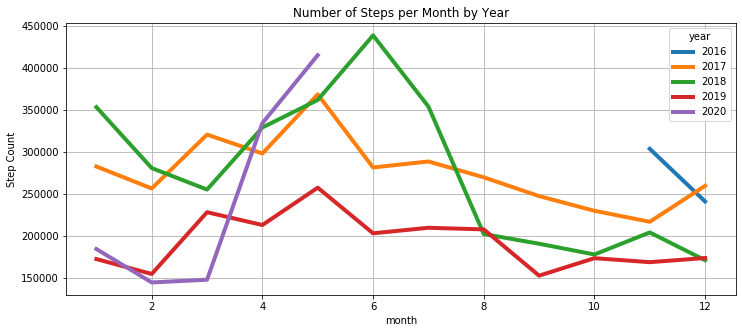

In [152]:
# Group data by year in pivot table
df2 = steps_by_date.copy()
df2['date'] = pd.to_datetime(df2['date'])
df2['year'] = df2['date'].dt.year
df2['month'] = df2['date'].dt.month

df3 = pd.pivot_table(df2, index='month', columns='year', values='Steps', aggfunc='sum')
chart_title = 'Number of Steps per Month by Year'

ax = df3.plot(kind='line', figsize=[12, 5], linewidth=4, alpha=1, marker='', 
                      markeredgecolor='#6684c1', markerfacecolor='w', markersize=8, markeredgewidth=2)

ax.yaxis.grid(True)
ax.xaxis.grid(True)
ax.set_ylabel('Step Count')
ax.set_title(chart_title)

# print(df3.min())
print(df3.max())

plt.show()

----

# Weight Data

In [222]:
#import apple data
weight = pd.read_csv("data/BodyMass.csv")
#keep only apple health data (the rest are copies)
weight = weight[weight.sourceName=='Health']
#sort and reindex
weight = weight.sort_values(by='startDate', ignore_index=True)

# parse out date and time elements as EST time
weight['startDate'] = pd.to_datetime(weight['startDate'], utc=True).dt.tz_convert('EST')
weight['endDate'] = pd.to_datetime(weight['endDate'], utc=True).dt.tz_convert('EST')
weight['date'] = weight['startDate'].dt.strftime('%Y-%m-%d')

#drop irrelevant columns and rename value to Weight
weight = weight[['value','date']]
weight.rename(columns={'value':'Weight'}, inplace=True)

# weight.head(10)

In [223]:
#import fitbit weight data
weight2 = pd.read_csv("data/fitbit_weight.csv")

weight2['Date'] = pd.to_datetime(weight2['Date'])
weight2['date'] = weight2['Date'].dt.strftime('%Y-%m-%d')
weight2 = weight2.drop(['Date','BMI'], axis=1)

# weight2.head(10)

In [224]:
#merge with fitbit data
weight = pd.concat([weight2,weight], ignore_index=True)
weight = weight.sort_values(['date', 'Weight'])

weight = weight.groupby(['date'])['Weight'].mean().reset_index(name='Weight')

Most recent weight 190.5
Most recent 7-day average weight 191.8
Most recent 30-day average weight 195.7
Most recent 6-month average weight 203.4
Most recent 1-year average weight 202.6


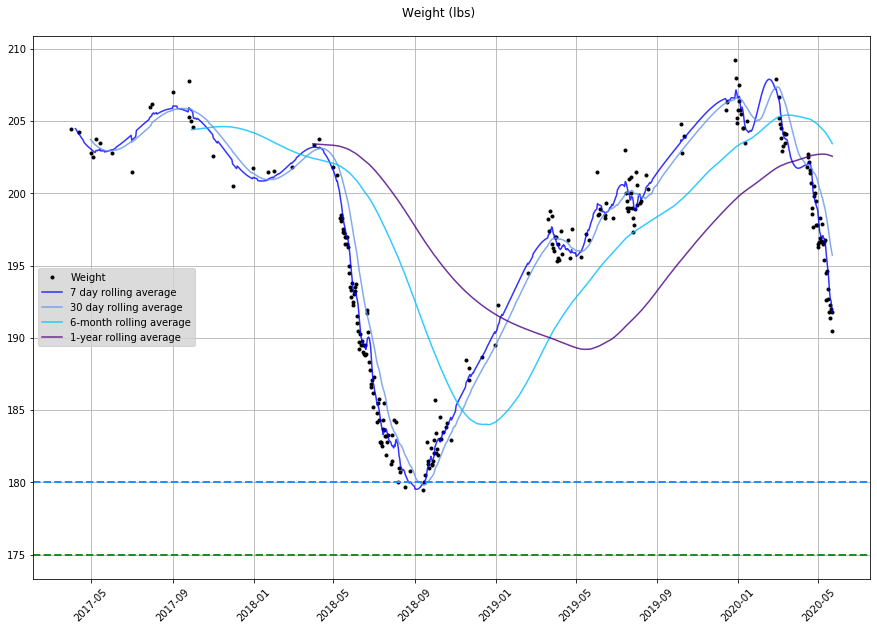

In [225]:
# parse out date and time elements
weight3 = weight.copy()
weight3['Date'] = pd.to_datetime(weight3['date'])

#sort by date and reindex
weight3 = weight3.sort_values(by='Date', ignore_index=True)

#set Date as index
weight3 = weight3.drop('date', axis=1).set_index('Date')
# print(weight3.head())

# resample by day and interpolate missing values using splines
weight4 = weight3.resample('D').interpolate(method='spline', order = 4, axis = 0)

#plot it
plt.figure(figsize=[15,10])
ax = plt.gca()
# ax.set_facecolor('whitesmoke')
plt.suptitle('Weight (lbs)', fontsize=12, y=.92)
plt.grid(True)
plt.plot(weight3['Weight'], 'k.', alpha=1,label='Weight')
plt.plot(weight4['Weight'].rolling(window=7, center=False).mean(), c='blue'\
         , alpha=0.8,label='7 day rolling average')
plt.plot(weight4['Weight'].rolling(window=30, center=False).mean(), c='cornflowerblue'\
         , alpha=0.8,label='30 day rolling average')
plt.plot(weight4['Weight'].rolling(window=182, center=False).mean(), c='deepskyblue'\
         , alpha=0.8,label='6-month rolling average')
plt.plot(weight4['Weight'].rolling(window=365, center=False).mean(), c='indigo'\
         , alpha=0.8,label='1-year rolling average')

ax.axhline(180, linewidth=2, color='dodgerblue', linestyle='dashed')#,label="10,000 per day")
ax.axhline(175, linewidth=2, color='forestgreen', linestyle='dashed')#,label="Global avg steps per day")

legend = ax.legend(loc=6, facecolor = 'lightgray')
# legend.facecolor('gray')
plt.xticks(rotation=45)

print("Most recent weight {}".format(weight3.Weight[-1]))
print("Most recent 7-day average weight {}".format(round(weight4['Weight'].rolling(window=7, center=False).mean()[-1],1)))
print("Most recent 30-day average weight {}".format(round(weight4['Weight'].rolling(window=30, center=False).mean()[-1],1)))
print("Most recent 6-month average weight {}".format(round(weight4['Weight'].rolling(window=182, center=False).mean()[-1],1)))
print("Most recent 1-year average weight {}".format(round(weight4['Weight'].rolling(window=365, center=False).mean()[-1],1)))
plt.show()

----

## Workout data 

In [226]:
Workout = pd.read_csv("data/Workout.csv")

# parse out date and time elements as EST time
Workout['startDate'] = pd.to_datetime(Workout['startDate'], utc=True).dt.tz_convert('EST')
Workout['endDate'] = pd.to_datetime(Workout['endDate'], utc=True).dt.tz_convert('EST')
Workout['date'] = Workout['startDate'].dt.strftime('%Y-%m-%d')

#Clean workout names
Workout['workoutActivityType'] = Workout['workoutActivityType'].str.replace('HKWorkoutActivityType','')

#round some feautures
Workout.duration = round(Workout.duration, 1)
Workout.totalEnergyBurned = round(Workout.totalEnergyBurned, 0)
Workout.totalDistance = round(Workout.totalDistance, 3)

#Delete unnecessary columns
Workout = Workout.drop(['sourceVersion', 'device', 'creationDate', 'durationUnit', 'totalDistanceUnit', 'totalEnergyBurnedUnit'], axis=1)

#drop duplicates
Workout.drop_duplicates(inplace=True) #removes true duplicates
Workout = Workout[Workout.startDate!='2018-06-25 05:20:40-05:00'].reset_index(drop=True)

print(Workout.head(20))
# print(Workout.tail(20))
print(Workout.shape)

            sourceName                 startDate                   endDate  \
0   Greg’s Apple Watch 2018-06-17 19:35:27-05:00 2018-06-17 20:53:40-05:00   
1   Greg’s Apple Watch 2018-06-18 05:26:41-05:00 2018-06-18 06:25:12-05:00   
2   Greg’s Apple Watch 2018-06-18 19:34:24-05:00 2018-06-18 20:12:07-05:00   
3   Greg’s Apple Watch 2018-06-19 08:22:28-05:00 2018-06-19 08:42:41-05:00   
4   Greg’s Apple Watch 2018-06-19 13:09:58-05:00 2018-06-19 13:45:12-05:00   
5   Greg’s Apple Watch 2018-06-20 14:06:48-05:00 2018-06-20 15:16:20-05:00   
6   Greg’s Apple Watch 2018-06-21 19:27:20-05:00 2018-06-21 20:05:03-05:00   
7   Greg’s Apple Watch 2018-06-22 05:19:31-05:00 2018-06-22 06:29:26-05:00   
8   Greg’s Apple Watch 2018-06-23 13:51:09-05:00 2018-06-23 15:04:20-05:00   
9   Greg’s Apple Watch 2018-06-24 09:28:58-05:00 2018-06-24 10:59:55-05:00   
10              Strava 2018-06-25 05:30:39-05:00 2018-06-25 06:21:21-05:00   
11  Greg’s Apple Watch 2018-06-25 12:51:57-05:00 2018-06-25 13:5

In [227]:
#Bicycle mileage
Cycling = Workout.copy()
Cycling = Cycling[Cycling.workoutActivityType=='Cycling'][['duration', 'totalDistance', 'totalEnergyBurned','date']].reset_index(drop=True)
Cycling['date'] = pd.to_datetime(Cycling.date)
Cycling['doy'] = Cycling.date.dt.dayofyear

print(Cycling.head(25))

    duration  totalDistance  totalEnergyBurned       date  doy
0       58.5          6.704              367.0 2018-06-18  169
1       69.9          8.186              420.0 2018-06-22  173
2       49.4          5.869                0.0 2018-06-25  176
3       83.5         10.045                0.0 2018-06-28  179
4       91.2         10.474              700.0 2018-07-02  183
5       79.5          9.724              646.0 2018-07-04  185
6       78.1          9.209              620.0 2018-07-06  187
7       16.8          0.917               42.0 2018-07-07  188
8      104.5         12.606              821.0 2018-07-09  190
9       72.8          9.305              631.0 2018-07-12  193
10      15.3          2.446              139.0 2019-03-23   82
11      52.0          6.290              375.0 2019-10-10  283
12      32.4          4.625              206.0 2020-04-08   99
13      53.1          7.908              396.0 2020-04-15  106
14      32.3          5.177              315.0 2020-05-

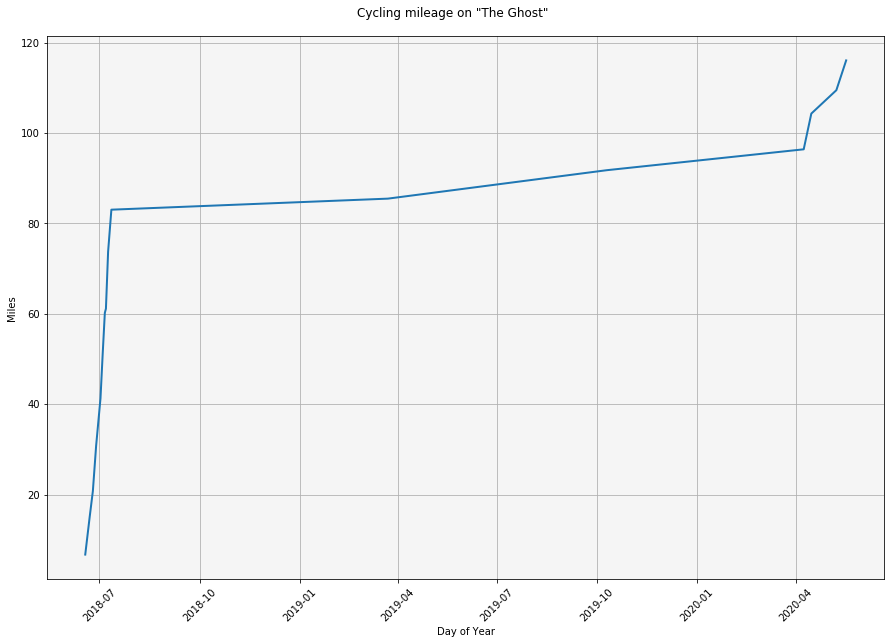

In [228]:
#plot 
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')

plt.suptitle('Cycling mileage on "The Ghost"', fontsize=12, y=.92)
plt.grid(True)
plt.plot(Cycling.date, Cycling.totalDistance.cumsum(), alpha=1, label = 'Walking', linewidth=2)

# plt.legend(loc=2)
plt.xlabel('Day of Year')
plt.ylabel('Miles')
plt.xticks(rotation=45)

plt.show()

In [230]:
#Create df with only walk/run and compute step metrics
Workout2 = Workout.copy()
Workout2['steps'] = np.nan
Workout2 = Workout2[(Workout2.workoutActivityType=='Walking')|(Workout2.workoutActivityType=='Running')]

#Calculate steps during activity taking max of phone/watch measurements
steps1 = steps[steps.sourceName=='Greg’s Apple\xa0Watch']
steps2 = steps[steps.sourceName=='Greg Ames’s iPhone']
for index, row in Workout2.iterrows():
    x1 = steps1[(steps1.startDate>=Workout2.startDate[index])\
              & (steps1.endDate<=Workout2.endDate[index])]
    x2 = steps2[(steps2.startDate>=Workout2.startDate[index])\
              & (steps2.endDate<=Workout2.endDate[index])]
    Workout2.loc[index, 'steps'] = max(x1.value.sum(), x2.value.sum())
      
Workout2['Steps_perMile'] = Workout2.steps/Workout2.totalDistance

#filter out SPM outliers
iqrW = Workout2[Workout2.workoutActivityType=='Walking'].Steps_perMile.quantile(.75)\
- Workout2[Workout2.workoutActivityType=='Walking'].Steps_perMile.quantile(.25)
l_limitW = Workout2[Workout2.workoutActivityType=='Walking'].Steps_perMile.quantile(.25) - 1.5 * iqrW
u_limitW = Workout2[Workout2.workoutActivityType=='Walking'].Steps_perMile.quantile(.75) + 1.5 * iqrW

iqrR = Workout2[Workout2.workoutActivityType=='Running'].Steps_perMile.quantile(.75)\
- Workout2[Workout2.workoutActivityType=='Running'].Steps_perMile.quantile(.25)
l_limitR = Workout2[Workout2.workoutActivityType=='Running'].Steps_perMile.quantile(.25) - 1.5 * iqrR
u_limitR = Workout2[Workout2.workoutActivityType=='Running'].Steps_perMile.quantile(.75) + 1.5 * iqrR

for index, row in Workout2.iterrows():
    if Workout2.workoutActivityType[index]=='Walking':
        if (Workout2.Steps_perMile[index]<l_limitW)|(Workout2.Steps_perMile[index]>u_limitW):
            Workout2.drop(index, inplace=True)
    elif Workout2.workoutActivityType[index]=='Running':
        if (Workout2.Steps_perMile[index]<l_limitR)|(Workout2.Steps_perMile[index]>u_limitR):
            Workout2.drop(index, inplace=True)
            
Workout2 = Workout2.reset_index(drop=True)
            
# print(Workout2.tail(25))

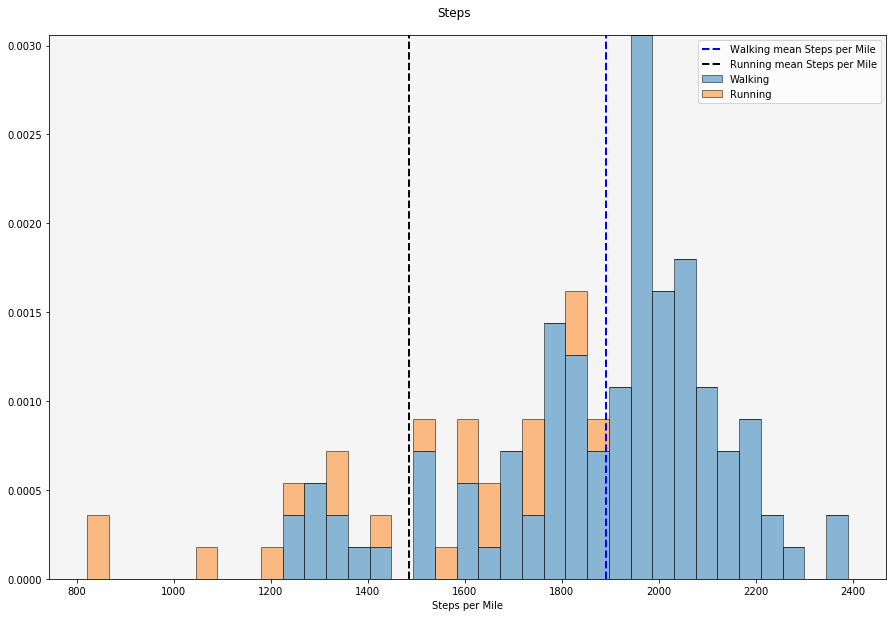

In [231]:
#Specify distribution parameters
bn = 35

#plot histogram of steps
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.suptitle('Steps', fontsize=12, y=.92)
n, bins, patches = plt.hist([Workout2[Workout2.workoutActivityType=='Walking'].Steps_perMile,\
                             Workout2[Workout2.workoutActivityType=='Running'].Steps_perMile], bn, density=True, alpha =0.5, histtype='barstacked', label=['Walking', 'Running'], edgecolor='black')

ax.axvline(Workout2[Workout2.workoutActivityType=='Walking'].Steps_perMile.mean(),\
           linewidth=2, color='b', linestyle='dashed',label="Walking mean Steps per Mile")
ax.axvline(Workout2[Workout2.workoutActivityType=='Running'].Steps_perMile.mean(),\
           linewidth=2, color='k', linestyle='dashed',label="Running mean Steps per Mile")

plt.xlabel('Steps per Mile')
plt.legend(loc=1)
plt.show()

Walking - coefficient of determination: 0.990324858664535
Walking - intercept: 0.29101636218329174
Walking - slope: [0.00046577]
Walking pace is [2147.] steps per mile.

Running - coefficient of determination: 0.8232272573016269
Running - intercept: 0.4911676037767889
Running - slope: [0.00055933]
Running pace is [1787.9] steps per mile.



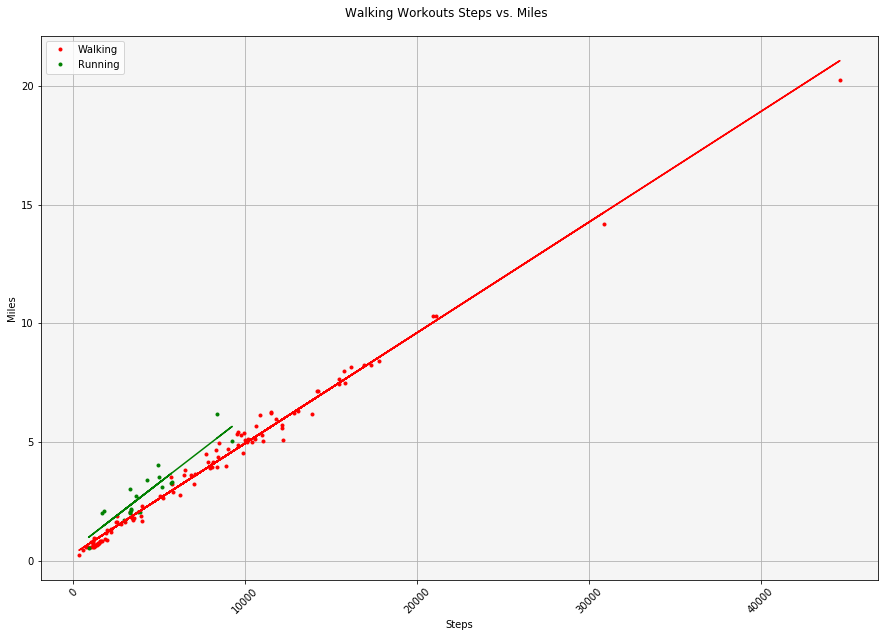

In [232]:
# Fit regression model for walking
x1 = Workout2[Workout2.workoutActivityType=='Walking'].steps.values.reshape((-1, 1))
y1 = Workout2[Workout2.workoutActivityType=='Walking'].totalDistance
model = LinearRegression(fit_intercept=True).fit(x1, y1)
r_sq = model.score(x1, y1)
y_pred = model.predict(x1)
print('Walking - coefficient of determination:', r_sq)
print('Walking - intercept:', model.intercept_)
print('Walking - slope:', model.coef_)
print('Walking pace is {} steps per mile.\n'.format(np.round(1/model.coef_,1)))

# Fit regression model for running
x2 = Workout2[Workout2.workoutActivityType=='Running'].steps.values.reshape((-1, 1))
y2 = Workout2[Workout2.workoutActivityType=='Running'].totalDistance
model2 = LinearRegression(fit_intercept=True).fit(x2, y2)
r_sq2 = model2.score(x2, y2)
y_pred2 = model2.predict(x2)
print('Running - coefficient of determination:', r_sq2)
print('Running - intercept:', model2.intercept_)
print('Running - slope:', model2.coef_)
print('Running pace is {} steps per mile.\n'.format(np.round(1/model2.coef_,1)))


#plot 
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')

plt.suptitle('Walking Workouts Steps vs. Miles', fontsize=12, y=.92)
plt.grid(True)
plt.plot(Workout2[Workout2.workoutActivityType=='Walking'].steps,\
         Workout2[Workout2.workoutActivityType=='Walking'].totalDistance, 'r.', alpha=1, label = 'Walking')
plt.plot(Workout2[Workout2.workoutActivityType=='Running'].steps,\
         Workout2[Workout2.workoutActivityType=='Running'].totalDistance, 'g.', alpha=1, label = 'Running')
plt.plot(x1,y_pred, 'r')
plt.plot(x2,y_pred2, 'g')
plt.legend(loc=2)
plt.xticks(rotation=45)
plt.xlabel('Steps')
plt.ylabel('Miles')

plt.show()

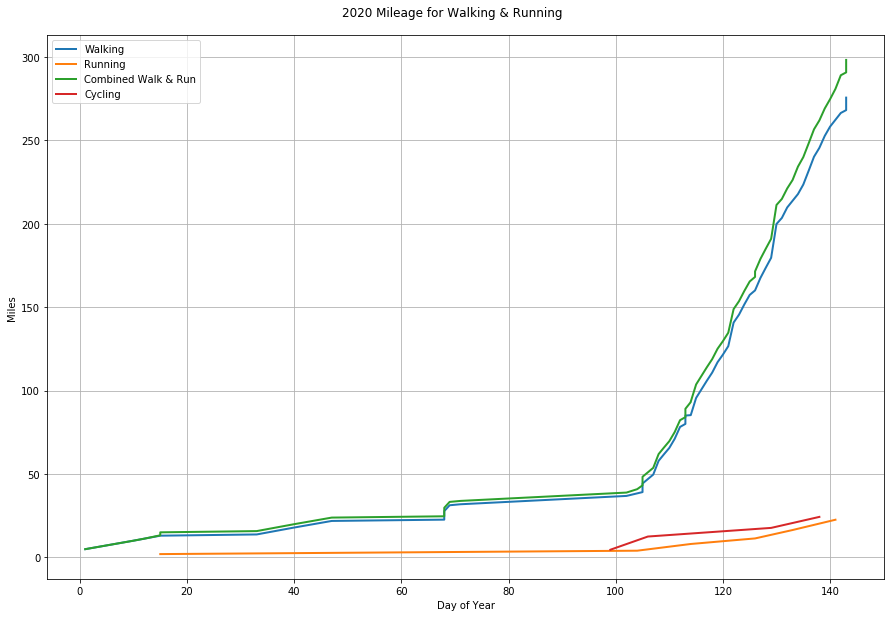

In [233]:
# Cumulative exercise mileage for the year
Workout2['date'] = pd.to_datetime(Workout2['date'])
Workout3 = Workout2[Workout2.date.dt.year==2020].copy().reset_index(drop=True)
Workout3['doy'] = Workout3['date'].dt.dayofyear

Workout3 = Workout3.set_index('doy')

# print(Workout3.head())

#plot 
plt.figure(figsize=[15,10])
ax = plt.gca()
# ax.set_facecolor('whitesmoke')

plt.suptitle('2020 Mileage for Walking & Running', fontsize=12, y=.92)
plt.grid(True)
plt.plot(Workout3[Workout3['workoutActivityType'] == 'Walking'].totalDistance.cumsum(),\
         alpha=1, label = 'Walking', linewidth=2)
plt.plot(Workout3[Workout3['workoutActivityType'] == 'Running'].totalDistance.cumsum(),\
         alpha=1, label = 'Running', linewidth=2)
plt.plot(Workout3.totalDistance.cumsum(), alpha=1, label = 'Combined Walk & Run', linewidth=2)
plt.plot(Cycling[Cycling.date.dt.year==2020].doy,\
         Cycling[Cycling.date.dt.year==2020].totalDistance.cumsum(), alpha=1, label = 'Cycling', linewidth=2)


plt.legend(loc=2)
plt.xlabel('Day of Year')
plt.ylabel('Miles')

plt.show()


------

## Heart Rate

### Resting Heart Rate

In [234]:
resting = pd.read_csv("data/RestingHeartRate.csv")
# print(resting.head())

# parse out date and time elements as EST time
resting['startDate'] = pd.to_datetime(resting['startDate'], utc=True).dt.tz_convert('EST')
resting['date'] = resting['startDate'].dt.strftime('%Y-%m-%d')

#Delete unnecessary columns
resting = resting[['date', 'value']]

# Creating daily average resting HR
resting_daily = resting.copy()
resting_daily = resting_daily.sort_values('date', ignore_index=True)
resting_daily = resting_daily.groupby(['date'])['value'].mean().reset_index(name='Resting_HR')
resting_daily['date'] = pd.to_datetime(resting_daily['date'])
resting_daily = resting_daily.set_index('date')

# print(resting_daily.head())

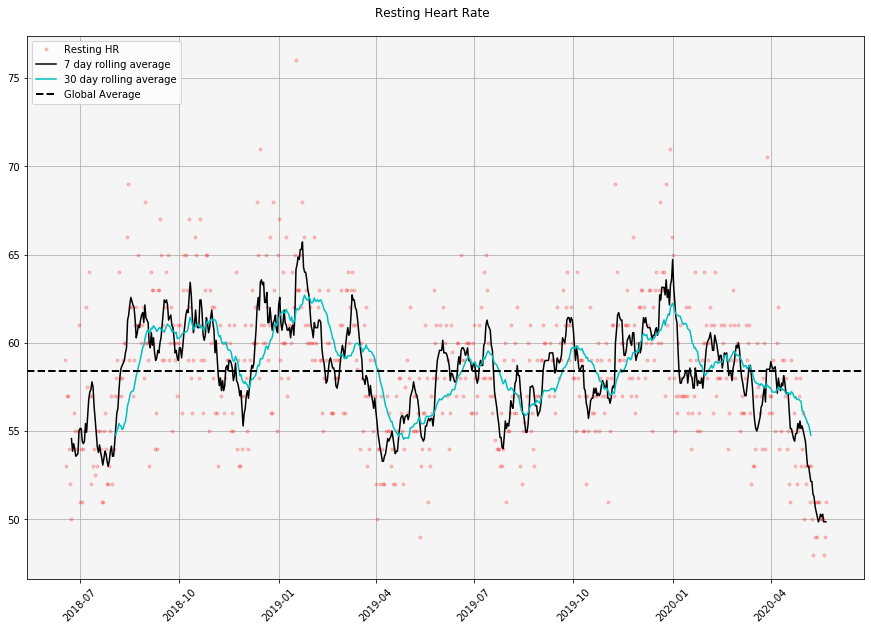

In [235]:
#plot resting HR with rolling avg
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.suptitle('Resting Heart Rate', fontsize=12, y=.92)
plt.grid(True)
plt.plot(resting_daily.Resting_HR, 'r.', alpha=0.2,label='Resting HR')
plt.plot(resting_daily.Resting_HR.rolling(window=7, center = False).mean(), c='k',label='7 day rolling average', alpha=1)
plt.plot(resting_daily2.Resting_HR.rolling(window=30, center = False).mean(), c='c',label='30 day rolling average', alpha=1)
ax.axhline(resting_daily['Resting_HR'].mean(), label = 'Global Average', linewidth=2, color='k', linestyle='dashed')

plt.legend(loc=2)
plt.xticks(rotation=45)

plt.show()

### Hourly Heart Rate

In [31]:
hr = pd.read_csv("data/HeartRate.csv")

# parse out date and time elements as EST time
hr['startDate'] = pd.to_datetime(hr['startDate'], utc=True).dt.tz_convert('EST')
# hr['date'] = hr['startDate'].dt.strftime('%Y-%m-%d')

#Delete unnecessary columns
hr = hr[['startDate', 'value']]

# hr.head()
# hr.tail()

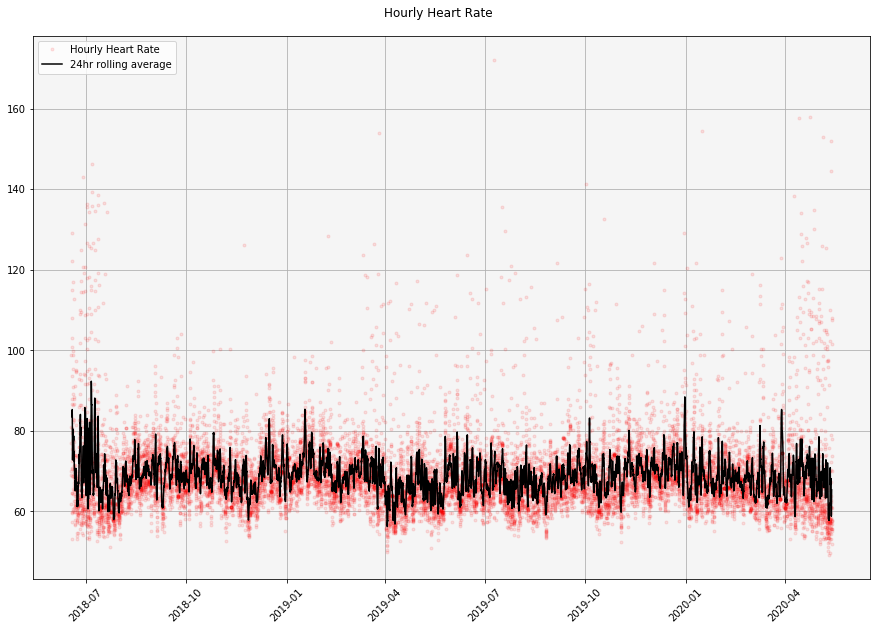

In [32]:
hr2 = hr.copy()
hr2 =hr2.sort_values('startDate', ignore_index=True)
hr2 = hr2.set_index('startDate')
hr2 = hr2.resample('H').mean()
hr2 = hr2.resample('H').interpolate(method='linear', axis = 0)

# print(hr2.head())

hr2['RollingHR'] = hr2.value.rolling(window=24, center = True).mean()

#plot resting HR with rolling avg
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')

plt.suptitle('Hourly Heart Rate', fontsize=12, y=.92)
plt.grid(True)
plt.plot(hr2['value'], 'r.', alpha=0.1,label='Hourly Heart Rate')
plt.plot(hr2['RollingHR'], c='k',label='24hr rolling average', alpha=1)

plt.legend(loc=2)
plt.xticks(rotation=45)

plt.show()